In [1]:
using AutomotiveDrivingModels
using AutoRisk
using AutoViz
using DataFrames
using Interact
using Records
using HDF5, JLD
using PGFPlots
using BenchmarkTools
using Reel

include("../AutoMobius/AutoMobius.jl")
include("../clustering/feature_extraction.jl")
using AutoMobius

loading records...
loading scenarios...
extracting features...
saving to file...


In [2]:
# load critical scenarios
data_dir = "../data/collision_scenarios"
list_records = load_records(data_dir)
critical_frames_filepath = "../data/clustering/critical_frames.txt"
scenarios = load_critical_scenarios(critical_frames_filepath, list_records);

In [3]:
# load classes
classes_filepath = "../data/clustering/classes.txt"
classes = readtable(classes_filepath);

In [4]:
# visualization
# note: the index of the scenario in each class is a bit of a hack
# as a result, the slider bar for it (idx) can only changes index after multiple increments
function visualize_scenarios_by_class(scenarios::Array{CriticalScenario}, classes::DataFrame)
    # share between visualizations 
    roadway = StraightRoadway(200.0) 
    scene = Scene1D()
    models = Dict{Int, LaneFollowingDriver}()
    
     # prepare film for save case
    frames = Frames(MIME("image/png"), fps=10)

    # visualize by class
    n_classes = length(unique(classes[:class]))
    class_indices = [find(classes[:class] .== c) for c in 1:n_classes]
    class_counts = [length(c) for c in class_indices]
    max_count = maximum(class_counts)
    @manipulate for class in collect(1:n_classes),
                    idx in 1:max_count,
                    frame in 1:600,
                    show_critical_frame_only in [false, true],
                    save in [false, true],
                    clear in [false, true]
        scaled_idx = Int(floor(class_counts[class] / max_count * idx))
        class_idx = class_indices[class][scaled_idx]
        empty!(scene)
        empty!(models)
        frame = show_critical_frame_only ? scenarios[class_idx].frame_ind : frame
        unpack!(scenarios[class_idx].rec, frame, scene, models)
        stats = SceneOverlay[AttentionOverlay(id, model) for (id,model) in models]
        frame = render(scene, roadway, stats, cam = StaticCamera(VecE2(100.0,0.0), 4.5))
        
        # saving and clearing works by 
        # (1) set clear to true then back to false 
        # (2) step through the frames to save as a gif slowly
        # (3) set save to true then back to false
        if save
            filename = "class_$(class)_idx_$(class_idx)"
            write("../../data/clustering/visualizations/$(filename).gif", frames)
            frames = Frames(MIME("image/png"), fps=5)
        end
        if clear
            frames = Frames(MIME("image/png"), fps=10)
        end
        
        frame
    end
end

visualize_scenarios_by_class (generic function with 1 method)

Interact.Options{:ToggleButtons,Int64}(input: Signal{Int64}(1, nactions=1),"class",1,"1",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4),Dict(4=>"4",2=>"2",3=>"3",1=>"1")),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(input-2: Signal{Int64}(147, nactions=1),"idx",147,"147",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(288=>"288",11=>"11",134=>"134",158=>"158",160=>"160",215=>"215",29=>"29",131=>"131",249=>"249",207=>"207"…)),Any[],Any[],true,"horizontal")

Interact.Options{:SelectionSlider,Int64}(input-3: Signal{Int64}(300, nactions=1),"frame",300,"300",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(288=>"288",306=>"306",520=>"520",11=>"11",491=>"491",134=>"134",158=>"158",160=>"160",215=>"215",464=>"464"…)),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(input-4: Signal{Bool}(false, nactions=1),"show_critical_frame_only",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(input-5: Signal{Bool}(false, nactions=1),"save",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

Interact.Options{:ToggleButtons,Bool}(input-6: Signal{Bool}(false, nactions=1),"clear",false,"false",Interact.OptionDict(DataStructures.OrderedDict("false"=>false,"true"=>true),Dict(false=>"false",true=>"true")),Any[],Any[],true,"horizontal")

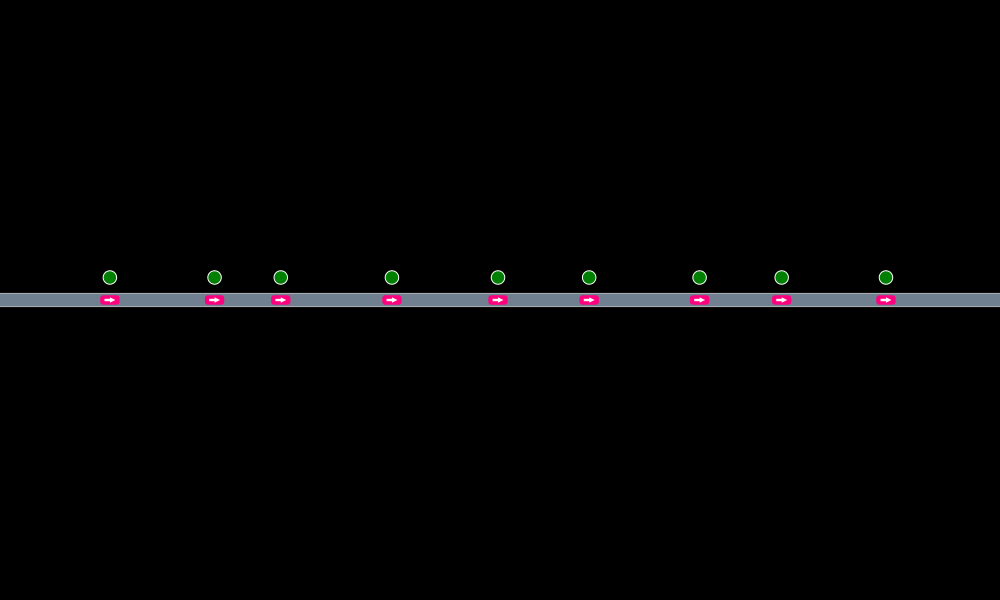

In [5]:
# run it!
visualize_scenarios_by_class(scenarios, classes)